# Compile lake info/stats into list

In [15]:
%matplotlib widget
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import h5py
import math
import datetime
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from icelakes.utilities import convert_time_to_string
from IPython.display import Image, display
from matplotlib.collections import PatchCollection
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, get_quality_summary, convert_time_to_string, read_melt_lake_h5

# Specify the directory where the data lives
Make sure this is the right one!

In [16]:
# base_dir = '/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeDetectionICESat2/'
base_dir = '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/'

In [17]:
out_data_dir = 'detection_out_data/'
out_plot_dir = 'detection_out_data/'
granule_stats_fn = '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/stats_combined_GLD2_except91granules.csv'

In [18]:
stats_column_names=['region', 'granule', 'xatc_total', 'xatc_lakes', 'nphot_total', 'nphot_lakes']
df_granule_stats = pd.read_csv(granule_stats_fn, header=None, names=stats_column_names)

In [19]:
total_xatc = df_granule_stats.xatc_total.sum()
lakes_xatc = df_granule_stats.xatc_lakes.sum()
total_photons = df_granule_stats.nphot_total.sum()
lakes_photons = df_granule_stats.nphot_lakes.sum()
print('Total along-track distance analyzed: %.1f million km (%.1f million miles)' % (total_xatc/1e9, total_xatc/1e9*0.621371))
print('Total along-track distance of lakes: %.1f thousand km (%.1f thousand miles)' % (lakes_xatc/1e6, lakes_xatc/1e6*0.621371))
print('Percentage that is lakes:            %.5f' % (lakes_xatc/total_xatc*100))
print('')
print('Total number of photons analyzed:    %i billion' % (total_photons/1e9))
print('Total number of lake photons:        %i million' % (lakes_photons/1e6))
print('Percentage that is lakes:            %.5f' % (lakes_photons/total_photons*100))

Total along-track distance analyzed: 60.2 million km (37.4 million miles)
Total along-track distance of lakes: 31.1 thousand km (19.3 thousand miles)
Percentage that is lakes:            0.05172

Total number of photons analyzed:    715 billion
Total number of lake photons:        307 million
Percentage that is lakes:            0.04301


# get lake info

In [20]:
searchfor = '.h5'
searchdir = base_dir + out_data_dir
filelist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
filelist.sort()
print('There are %i data files.' % len(filelist))
zerolakes = [f for f in filelist if 'lake_10000000_' in f]
print('There are %i files with zero quality.' % len(zerolakes))

There are 25094 data files.
There are 14932 files with zero quality.


In [21]:
searchfor_img = '.jpg'
searchdir = base_dir + out_plot_dir
filelist_plot = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor_img in f)]
filelist_plot.sort()
print('There are %i plot files.' % len(filelist_plot))

There are 25093 plot files.


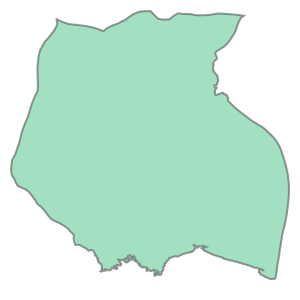

In [22]:
from shapely.geometry import Point
fn_basins = '../GlacierLakeDetectionICESat2/basins/shapefiles/ANT_basins_merged.shp'
gdf = gpd.read_file(fn_basins).set_index('Subregions')
ep_f = gdf.loc['Ep-F'].geometry
ep_f

# Run this to compile lake stats by reading in all the available data files

In [42]:
num_missing_data = 0

for i,fn in enumerate(filelist):
    print('reading file %5i / %5i' % (i+1, len(filelist)), end='\r')

    try:
        with h5py.File(fn, 'r+') as f:
            ice_sheet = f['properties']['ice_sheet'][()].decode('utf-8')
            melt_season = f['properties']['melt_season'][()].decode('utf-8')
            polygon_name = f['properties']['polygon_name'][()].decode('utf-8')
            max_depth = f['properties']['max_depth'][()]
            length_water_surfaces = f['properties']['length_water_surfaces'][()]
            surface_elevation = f['properties']['surface_elevation'][()]
            n_photons_where_water = f['properties']['n_photons_where_water'][()]
            lon = f['properties']['lon'][()]
            lat = f['properties']['lat'][()]
            lon_min = f['properties']['lon_min'][()]
            lon_max = f['properties']['lon_max'][()]
            lat_min = f['properties']['lat_min'][()]
            lat_max = f['properties']['lat_max'][()]
            cycle_number = f['properties']['cycle_number'][()]
            rgt = f['properties']['rgt'][()]
            gtx = f['properties']['gtx'][()].decode('utf-8')
            beam_strength = f['properties']['beam_strength'][()].decode('utf-8')
            beam_number = f['properties']['beam_number'][()]
            granule_id = f['properties']['granule_id'][()].decode('utf-8')
            lake_id = f['properties']['lake_id'][()].decode('utf-8')
            
            date_time = convert_time_to_string(np.mean(f['mframe_data']['dt'][()]))
            lake_quality = f['properties']['lake_quality'][()]
            detection_quality = f['properties']['detection_quality'][()]
            quality_summary = f['properties']['quality_summary'][()]

            #############################################
            if 'test_filchner' in polygon_name:
                polygon_name = 'geojsons/simplified_ANT_1000_West_J-Jpp.geojson'
                del f['properties/polygon_name']
                dset = f.create_dataset('properties/polygon_name', data=polygon_name)

            if 'test_ross' in polygon_name:
                polygon_name = 'geojsons/simplified_ANT_1000_East_E-Ep.geojson'
                del f['properties/polygon_name']
                dset = f.create_dataset('properties/polygon_name', data=polygon_name)

            if ('_E-Ep' in polygon_name) or ('_Ep-F' in polygon_name):
                pt = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs='EPSG:4326').to_crs(gdf.crs).loc[0].geometry
                if pt.within(ep_f):
                    polygon_name = 'geojsons/simplified_ANT_1000_West_Ep-F.geojson'
                    print(polygon_name)
                else:
                    polygon_name = 'geojsons/simplified_ANT_1000_East_E-Ep.geojson'
                del f['properties/polygon_name']
                dset = f.create_dataset('properties/polygon_name', data=polygon_name)
            #############################################
        
        basin = polygon_name.replace('simplified_', '')
        file_name = fn
    
        datadict = {
            'ice_sheet': ice_sheet,
            'melt_season': melt_season,
            'basin': basin,
            'quality_summary': quality_summary,
            'max_depth': max_depth,
            'length_water_surfaces': length_water_surfaces,
            'surface_elevation': surface_elevation,
            'n_photons_where_water': n_photons_where_water,
            'lon': lon,
            'lat': lat,
            'date_time': date_time,
            'lon_min': lon_min,
            'lon_max': lon_max,
            'lat_min': lat_min,
            'lat_max': lat_max,
            'cycle_number': cycle_number,
            'rgt': rgt,
            'gtx': gtx,
            'beam_strength': beam_strength,
            'beam_number': beam_number,
            'detection_quality': detection_quality,
            'lake_quality': lake_quality,
            'granule_id': granule_id,
            'lake_id': lake_id,
            'file_name': file_name
        }
    
        if i == 0: 
            df = pd.DataFrame(datadict, index=[0])
        else:
            df.loc[i] = datadict.values()

    except:
        num_missing_data += 1

print('\nNumber of lakes with missing data: %i' % num_missing_data)

df['main_region'] = df.apply(lambda x: 'AIS_'+x.basin.split('_')[2] if x.ice_sheet == 'AIS' else None, axis=1)
df['basin_name'] = df.apply(lambda x: x.basin.split('_')[-1], axis=1)

df

In [ ]:
# df.loc[df.basin=='test_ross','basin'] = 'geojsons/simplified_ANT_1000_East_E-Ep.geojson'
# df.loc[df.basin=='test_ross','lake_id'] = df.loc[df.basin=='test_ross','lake_id'].replace('test_ross','simplified_ANT_1000_East_E-Ep')
# df['main_region'] = df.apply(lambda x: 'AIS_'+x.basin.split('_')[2] if x.ice_sheet == 'AIS' else None, axis=1)
# df['basin_name'] = df.apply(lambda x: x.basin.split('_')[-1], axis=1)

# df

# Save the lake info to a csv file

In [49]:
out_file_csv = 'GLD2_lakestats_for-wais_ross-fixed_all.csv'

out_path_csv = base_dir + out_file_csv
df.to_csv(out_path_csv, index=False)
print(out_path_csv)
# '/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeDetectionICESat2/GLD1_all_lakes.csv'
# '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/GLD2_all_returned_lakes.csv'
# '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/GLD2_lakestats_for-wais.csv'
# /Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/GLD2_lakestats_for-wais_ross-fixed.csv
# /Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/GLD2_lakestats_for-wais_ross-fixed_all.csv

/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/GLD2_lakestats_for-wais_ross-fixed_all.csv


# Check that it worked 

In [48]:
out_path_csv = '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/GLD2_lakestats_for-wais_ross-fixed_all.csv'
df = pd.read_csv(out_path_csv)
df['basin'] = df.apply(lambda x: x.basin.replace('geojsons/', '').replace('.geojson',''), axis=1)
np.unique(df.basin)

array(['ANT_1000_East_A-Ap', 'ANT_1000_East_Ap-B', 'ANT_1000_East_B-C',
       'ANT_1000_East_C-Cp', 'ANT_1000_East_Cp-D', 'ANT_1000_East_D-Dp',
       'ANT_1000_East_Dp-E', 'ANT_1000_East_E-Ep', 'ANT_1000_East_Jpp-K',
       'ANT_1000_East_K-A', 'ANT_1000_Peninsula_Hp-I',
       'ANT_1000_Peninsula_I-Ipp', 'ANT_1000_Peninsula_Ipp-J',
       'ANT_1000_West_Ep-F', 'ANT_1000_West_F-G', 'ANT_1000_West_G-H',
       'ANT_1000_West_H-Hp', 'ANT_1000_West_J-Jpp', 'GRE_2000_CE',
       'GRE_2000_CW', 'GRE_2000_NE', 'GRE_2000_NO', 'GRE_2000_NW',
       'GRE_2000_SE', 'GRE_2000_SW'], dtype=object)

# Subset for good lakes only for WAIS Conference

In [33]:
to_remove = [
    'lake_09999770_AIS_2020-21_simplified_ANT_1000_West_Ep-F_ATL03_20210319070241_13021012_006_01_gt1l_0000.h5',
    'lake_09999783_AIS_2019-20_simplified_ANT_1000_East_K-A_ATL03_20191104231510_05960512_006_01_gt3l_0018.h5',
    'lake_09999834_AIS_2019-20_simplified_ANT_1000_Peninsula_I-Ipp_ATL03_20200222201311_08870612_006_01_gt2r_0000.h5',
    'lake_09994291_AIS_2020-21_simplified_ANT_1000_West_F-G_ATL03_20201125223347_09580910_006_01_gt2l_0000.h5',
    'lake_09999865_AIS_2021-22_simplified_ANT_1000_West_H-Hp_ATL03_20211229140312_01111412_006_01_gt2l_0000.h5',
]

wais_list = 'lakelistgood_temp20230922.csv'
df_sel = pd.read_csv(wais_list,header=None,names=['filename'])
df_sel.iloc[0].filename
df_sel['qual_int'] = df_sel.apply(lambda x: int(x.filename.split('_')[1]), axis=1)
df_sel['is_data'] = df_sel.apply(lambda x: '.h5' in x.filename, axis=1)
df_sel = df_sel[df_sel.is_data & (df_sel.qual_int != 10000000)].reset_index(drop=True)
df['fn_only'] = df.apply(lambda x: x.file_name.split('/')[-1], axis=1)
filelist_good = list(df_sel.filename)
df['is_good_wais'] = df.apply(lambda x: (x.fn_only in filelist_good) and (x.fn_only not in to_remove), axis=1)
df_forwais = df[df.is_good_wais]
df_forwais['basin']= df_forwais.apply(lambda x: x.basin.replace('geojsons/', '').replace('.geojson', ''), axis=1)
df_forwais['basin_name']= df_forwais.apply(lambda x: x.basin.replace('geojsons/', '').replace('.geojson', ''), axis=1)
df_forwais

waislist_out = '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/GLD2_lakestats_for-wais_ross-fix_gooddata.csv'
df_forwais.to_csv(waislist_out, index=False)

In [37]:
df = pd.read_csv('/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/GLD2_lakestats_for-wais_ross-fix_gooddata.csv')
df_ant = df[df.ice_sheet=='AIS']
df.groupby('basin_name')['lake_id'].count()

basin_name
ANT_1000_East_A-Ap           103
ANT_1000_East_Ap-B            30
ANT_1000_East_B-C            735
ANT_1000_East_C-Cp            65
ANT_1000_East_Cp-D             7
ANT_1000_East_Dp-E            85
ANT_1000_East_E-Ep           254
ANT_1000_East_Jpp-K           11
ANT_1000_East_K-A              9
ANT_1000_Peninsula_Hp-I      196
ANT_1000_Peninsula_I-Ipp      42
ANT_1000_Peninsula_Ipp-J       1
ANT_1000_West_Ep-F            14
ANT_1000_West_F-G              1
ANT_1000_West_G-H             19
ANT_1000_West_J-Jpp            2
GRE_2000_CE                  225
GRE_2000_CW                  693
GRE_2000_NE                 1038
GRE_2000_NO                  821
GRE_2000_NW                  756
GRE_2000_SE                   19
GRE_2000_SW                  956
Name: lake_id, dtype: int64

# now get granule stats from the actual selected data

In [38]:
total_xatc = df_granule_stats.xatc_total.sum()
lakes_xatc = df.length_water_surfaces.sum()
total_photons = df_granule_stats.nphot_total.sum()
lakes_photons = df.n_photons_where_water.sum()
print('Total along-track distance analyzed:  %.1f million km (%.1f million miles)' % (total_xatc/1e9, total_xatc/1e9*0.621371))
print('Total along-track distance of lakes:  %.1f thousand km (%.1f thousand miles)' % (lakes_xatc/1e6, lakes_xatc/1e6*0.621371))
print('')
print('Total number of photons analyzed:     %i billion' % (total_photons/1e9))
print('Total number of lake photons:         %i million' % (lakes_photons/1e6))
print('')
print('Along-track distance lake percentage: %.3f %%' % (lakes_xatc/total_xatc*100))
print('Photon count percentage:              %.3f %%' % (lakes_photons/total_photons*100))

Total along-track distance analyzed:  60.2 million km (37.4 million miles)
Total along-track distance of lakes:  4.0 thousand km (2.5 thousand miles)

Total number of photons analyzed:     715 billion
Total number of lake photons:         70 million

Along-track distance lake percentage: 0.007 %
Photon count percentage:              0.010 %


### This shows that lake segements have a lower photon density than non-lake ones. 
This at first seems counterintuitive, but lakes are harder to detect when there is more background noise...

# Now get the stats for all regions

In [41]:
df['main_region'] = df.apply(lambda x: 'AIS_'+x.basin.split('_')[2] if x.ice_sheet == 'AIS' else None, axis=1)
df['basin_name'] = df.apply(lambda x: x.basin.split('_')[-1], axis=1)
df_granule_stats['ice_sheet'] = df_granule_stats.apply(lambda x: 'AIS' if x.region[:3] == 'ANT' else 'GrIS', axis=1)
df_granule_stats['main_region'] = df_granule_stats.apply(lambda x: 'AIS_'+x.region.split('_')[2] if x.ice_sheet == 'AIS' else None, axis=1)
df_granule_stats['basin_name'] = df_granule_stats.apply(lambda x: x.region.split('_')[3][:-8] if x.ice_sheet == 'AIS' else x.region.split('_')[2][:-8], axis=1)

def get_counts_by_region(df_g, df_l, group='ice_sheet'):
    if group=='all':
        granule_stats = pd.DataFrame(df_g[['xatc_total', 'nphot_total']].sum().to_dict(), index=['Total'])
        lake_stats = pd.DataFrame(df_l[['length_water_surfaces', 'n_photons_where_water']].sum().to_dict(), index=['Total'])
    else:
        granule_stats = df_g.groupby(by=group)[['xatc_total', 'nphot_total']].sum()
        lake_stats = df_l.groupby(by=group)[['length_water_surfaces', 'n_photons_where_water']].sum()
    stats_merge = pd.concat((granule_stats, lake_stats), axis=1)
    stats_merge['percentage_xatc'] = stats_merge.length_water_surfaces/stats_merge.xatc_total*100
    stats_merge['percentage_photons'] = stats_merge.n_photons_where_water/stats_merge.nphot_total*100
    return stats_merge

dfs_stat = []
for grp in ['all', 'ice_sheet', 'main_region', 'basin_name']:
    dfs_stat.append(get_counts_by_region(df_granule_stats, df, group=grp))
df_stats = pd.concat(dfs_stat)
df_stats.to_csv('/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/GLD2_granulestats_for-wais_ross-fix_gooddata.csv')
df_stats

,xatc_total,nphot_total,length_water_surfaces,n_photons_where_water,percentage_xatc,percentage_photons
Total,6.015410e+10,7.154003e+11,3989211.0,70566583.0,0.006632,0.009864
AIS,5.210968e+10,5.939038e+11,1046559.0,20612732.0,0.002008,0.003471
GrIS,8.044415e+09,1.214965e+11,2942652.0,49953851.0,0.036580,0.041115
AIS_East,2.124661e+10,2.783583e+11,894515.0,16741211.0,0.004210,0.006014
AIS_Peninsula,3.569008e+09,6.142514e+10,133114.0,3527734.0,0.003730,0.005743
AIS_West,2.729407e+10,2.541204e+11,18930.0,343787.0,0.000069,0.000135
A-Ap,2.415672e+09,3.944049e+10,93798.0,1488744.0,0.003883,0.003775
Ap-B,8.508537e+08,1.977151e+10,8323.0,150859.0,0.000978,0.000763
B-C,1.329537e+09,1.580630e+10,556529.0,9227014.0,0.041859,0.058376
C-Cp,9.089080e+08,1.949024e+10,36296.0,750357.0,0.003993,0.003850


# Code below for random plotting to check things...

In [ ]:
dfsort = df.sort_values(by='quality_summary', ascending=False)
df_ant = dfsort[dfsort.ice_sheet=='AIS'].reset_index(drop=True)
df_gre = dfsort[dfsort.ice_sheet=='GrIS'].reset_index(drop=True)
# df_ant['papergranule'] = df_ant.apply(lambda x: 'ATL03_20190102184312_00810210_' in x.granule_id ,axis=1)
# df_ant = df_ant[df_ant.papergranule & (df_ant.gtx=='gt2l')].reset_index(drop=True)

In [ ]:
for i in range(10):
    fn = df_ant.loc[i].file_name
    fig, ax = plt.subplots(figsize=[8,5])
    with h5py.File(fn, 'r') as f:
        xatc = f['photon_data']['xatc'][()]
        h = f['photon_data']['h'][()]
    ax.scatter(xatc, h, s=1, c='k')

In [ ]:
df_lakes = df[((df.quality_summary > 0) 
               & (df.surface_elevation > 1.0) 
               & (df.max_depth < 50) 
               & (df.max_depth > 0.5))].copy()
# df_lakes = df[df.quality_summary > 0]
df_lakes.sort_values(by='quality_summary', ascending=False, inplace=True)
len(df_lakes)

In [ ]:
sz_sup = 14
sz_tit_l = 12
sz_tit_s = 7
sz_lab_l = 10
sz_lab_s = 6
sz_tck_l = 8
sz_tck_s = 5
colors = {'GrIS': '#D00C33', # Greenland flag
          'AIS': '#3A7DCE' # Antarctica, Graham Bartram Design
         }

In [ ]:
fig, axs = plt.subplots(figsize=[8,4], ncols=2)
step = 25
for i,sheet in enumerate(['AIS', 'GrIS']):
    dfi = df_lakes[df_lakes.ice_sheet == sheet]
    uplim = 1000 if sheet=='AIS' else 2000
    sheet_name = 'Antarctic Ice Sheet' if sheet=='AIS' else 'Greenland Ice Sheet'
    bins = np.arange(0,uplim+step,step)
    mids = bins[:-1] + np.diff(bins)
    hist = np.histogram(dfi.surface_elevation, bins=bins)[0]
    ax = axs[i]
    ax.bar(mids, hist, np.diff(bins)[0], color=colors[sheet])
    ax.set_title(sheet_name, fontsize=sz_tit_l)
    if i==0:
        ax.set_ylabel('counts of lakes per %i m bin' % step, fontsize=sz_lab_l)
    ax.set_xlabel('elevation above geoid (m)', fontsize=sz_lab_l)
    ax.set_xlim((0,uplim))
    ax.tick_params(axis='both', labelsize=sz_tck_l)

fig.suptitle('surface elevation distributions of ICESat-2 lakes', fontsize=sz_sup)
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(figsize=[6,6], ncols=5, nrows=5)
axs = axs.flatten()
basins = np.unique(df_lakes.basin)
# maybe order basins in a reasonable way??

step = 50
for i,basin in enumerate(basins):
    dfi = df_lakes[df_lakes.basin == basin]
    sheet = 'AIS' if basin[:3]=='ANT' else 'GrIS'
    parms = basin.split('_')
    if sheet == 'AIS':
        basin_disp = '%s (%s)' % (parms[3], parms[2])
        basin_name = parms[3]
    else:
        basin_disp = parms[2]
        basin_name = basin_disp

    uplim = 1000 if sheet=='AIS' else 2000
    bins = np.arange(0,uplim+step,step)
    mids = bins[:-1] + np.diff(bins)
    hist = np.histogram(dfi.surface_elevation, bins=bins)[0]
    ax = axs[i]
    ax.bar(mids, hist, np.diff(bins)[0], color=colors[sheet])
    ax.set_title(basin_disp, fontsize=sz_tit_s)
    if i%5==0:
        ax.set_ylabel('counts', fontsize=sz_lab_s)
    if i>=20:
        ax.set_xlabel('elevation (m)', fontsize=sz_lab_s)
    ax.set_xlim((0,uplim))
    ax.tick_params(axis='both', labelsize=sz_tck_s)
    
fig.tight_layout(pad=0.2, h_pad=0.5, w_pad=0.5)

In [ ]:
import matplotlib.gridspec as gridspec
sz_sup = 12
sz_tit_l = 10
sz_tit_s = 7
sz_lab_l = 8
sz_lab_s = 6
sz_tck_l = 8
sz_tck_s = 5
colors = {'GrIS': '#D00C33', # Greenland flag
          'AIS': '#3A7DCE' # Antarctica, Graham Bartram Design
         }

fig = plt.figure(figsize=[10,10])
spec = gridspec.GridSpec(ncols=10, nrows=15, figure=fig)
axs = []
axs.append(fig.add_subplot(spec[:5, :5]))
axs.append(fig.add_subplot(spec[:5, 5:]))
for i in range(25):
    xloc = 5 + int(i/5)*2
    yloc = (i%5) * 2
    axs.append(fig.add_subplot(spec[xloc:xloc+2, yloc:yloc+2]))

step = 25
for i,sheet in enumerate(['AIS', 'GrIS']):
    dfi = df_lakes[df_lakes.ice_sheet == sheet]
    uplim = 1000 if sheet=='AIS' else 2000
    sheet_name = 'Antarctic Ice Sheet' if sheet=='AIS' else 'Greenland Ice Sheet'
    bins = np.arange(0,uplim+step,step)
    mids = bins[:-1] + np.diff(bins)
    hist = np.histogram(dfi.surface_elevation, bins=bins)[0]
    ax = axs[i]
    ax.bar(mids, hist, np.diff(bins)[0], color=colors[sheet])
    ax.set_title(sheet_name, fontsize=sz_tit_l)
    if i==0:
        ax.set_ylabel('counts of lakes per %i m bin' % step, fontsize=sz_lab_l)
    ax.set_xlabel('elevation above geoid (m)\n', fontsize=sz_lab_l)
    ax.set_xlim((0,uplim))
    ax.tick_params(axis='both', labelsize=sz_tck_l)

basins = np.unique(df_lakes.basin)
# maybe order basins in a reasonable way??
step = 50
for i,basin in enumerate(basins):
    dfi = df_lakes[df_lakes.basin == basin]
    sheet = 'AIS' if basin[:3]=='ANT' else 'GrIS'
    parms = basin.split('_')
    if sheet == 'AIS':
        basin_disp = '%s (%s)' % (parms[3], parms[2])
        basin_name = parms[3]
    else:
        basin_disp = parms[2]
        basin_name = basin_disp

    uplim = 1000 if sheet=='AIS' else 2000
    bins = np.arange(0,uplim+step,step)
    mids = bins[:-1] + np.diff(bins)
    hist = np.histogram(dfi.surface_elevation, bins=bins)[0]
    ax = axs[i+2]
    ax.bar(mids, hist, np.diff(bins)[0], color=colors[sheet])
    ax.margins(x=0, y=0)
    # if i%5==0:
    #     ax.set_ylabel('counts', fontsize=sz_lab_s, labelpad=1)
    # if i>=20:
    #     ax.set_xlabel('elevation', fontsize=sz_lab_s, labelpad=1)
    ax.set_xlim((0,uplim))
    ax.tick_params(axis='both', labelsize=sz_tck_s)
    ax.text(0.5, 1.03, basin_disp, fontsize=sz_tit_s, transform=ax.transAxes, ha='center', va='bottom')

fig.suptitle('surface elevation distributions of ICESat-2 lakes', fontsize=sz_sup)
fig.tight_layout(h_pad=0.01, w_pad=0.01)

In [ ]:
df_lakes_hq = df_lakes[df_lakes.quality_summary > 0.0]
len(df_lakes_hq)

In [ ]:
import calendar


In [ ]:
tckdtms = [datetime.datetime(2019,m,1) for m in np.arange(5,10)]
tckdoys = [d.timetuple().tm_yday for d in tckdtms]
tckstrs = [datetime.datetime.strftime(d, '%b %d') for d in tckdtms]
tckstrs

In [ ]:
import calendar
def get_doy(x):
    doy = x.dtime.timetuple().tm_yday
    if calendar.isleap(x.dtime.year):
        if doy==60:
            doy = -1
        if doy>60:
            doy -= 1
    return doy
    
fig, axs = plt.subplots(figsize=[8,4], ncols=2)
step = 25
for i,sheet in enumerate(['AIS', 'GrIS']):
    dfi = df_lakes_hq[df_lakes_hq.ice_sheet == sheet]
    dfdt = dfi[['ice_sheet', 'basin', 'date_time', 'quality_summary']].copy()
    dfdt['dtime'] = dfdt.apply(lambda x: datetime.datetime.strptime(x.date_time,'%Y-%m-%dT%H:%M:%SZ'), axis=1)
    dfdt['doy'] = dfdt.apply(get_doy, axis=1)
    cnts = dfdt.groupby('doy')['dtime'].count()
    if -1 in cnts.index:
        cnts = cnts.drop([-1]) # drop feb 29 values
    dayhist = pd.DataFrame({'doy': np.array(cnts.index), 'cnts': np.array(cnts)})
    dayhist.loc[dayhist.doy>300,'doy'] -= 365
    ax = axs[i]
    ax.bar(dayhist.doy, dayhist.cnts, 1, color=colors[sheet])
    months = [5, 6, 7, 8, 9, 10] if sheet == 'GrIS' else [11, 12, 1, 2, 3, 4]
    tckdtms = [datetime.datetime(2019,m,1) for m in months]
    tckdoys = [d.timetuple().tm_yday for d in tckdtms]
    tckdoys = [d-365 if d>300 else d for d in tckdoys]
    tckstrs = [datetime.datetime.strftime(d, '%b %d') for d in tckdtms]
    ax.set_xticks(tckdoys)
    ax.set_xticklabels(tckstrs)
    print(tckdoys, tckstrs)

    sheet_name = 'Antarctic Ice Sheet' if sheet=='AIS' else 'Greenland Ice Sheet'
    ax.set_title(sheet_name, fontsize=sz_tit_l)
    if i==0:
        ax.set_ylabel('counts of lakes by day of year', fontsize=sz_lab_l)
    ax.set_xlabel('time of year', fontsize=sz_lab_l)
    ax.set_xlim((tckdoys[0], tckdoys[-1]))
    ax.tick_params(axis='both', labelsize=sz_tck_l)

fig.suptitle('time of year for ICESat-2 lakes', fontsize=sz_sup)
fig.tight_layout()

In [ ]:
fn_basin = '../GlacierLakeDetectionICESat2/basins/shapefiles/Basins_Antarctica_v02.shp'
fn_shelf = '../GlacierLakeDetectionICESat2/basins/shapefiles/IceShelf_Antarctica_v02.shp'
fn_coast = '../GlacierLakeDetectionICESat2/basins/shapefiles/Coastline_Antarctica_v02.shp'
fn_ground = '../GlacierLakeDetectionICESat2/basins/shapefiles/GroundingLine_Antarctica_v02.shp'
fn_merged =  '../GlacierLakeDetectionICESat2/basins/shapefiles/ANT_basins_merged.shp'
fn_thresh = '../GlacierLakeDetectionICESat2/basins/shapefiles/ANT_basins_thresh1000.shp'

ant_gdf_basin = gpd.read_file(fn_basin)
ant_gdf_shelf = gpd.read_file(fn_shelf)
ant_gdf_coast = gpd.read_file(fn_coast)
ant_gdf_ground = gpd.read_file(fn_ground)
ant_gdf_merged = gpd.read_file(fn_merged)
ant_gdf_thresh = gpd.read_file(fn_thresh)

fn_basin = '../GlacierLakeDetectionICESat2/basins/shapefiles/Greenland_Basins_PS_v1.4.2.shp'
fn_merged = '../GlacierLakeDetectionICESat2/basins/shapefiles/GRE_basins_merged.shp'
fn_thresh = '../GlacierLakeDetectionICESat2/basins/shapefiles/GRE_basins_thresh2000.shp'
gre_gdf_basin = gpd.read_file(fn_basin)
gre_gdf_basin['geometry'] = gre_gdf_basin.geometry.buffer(1)
gre_gdf_merged = gpd.read_file(fn_merged)
gre_gdf_thresh = gpd.read_file(fn_thresh)

In [ ]:
gdf_lakes = gpd.GeoDataFrame(df_lakes, geometry=gpd.points_from_xy(df_lakes.lon, df_lakes.lat), crs="EPSG:4326")
gdf_ant = gdf_lakes[gdf_lakes.ice_sheet=='AIS'].to_crs(ant_gdf_basin.crs)
gdf_gre = gdf_lakes[gdf_lakes.ice_sheet=='GrIS'].to_crs(gre_gdf_basin.crs)
for gdf in [gdf_ant, gdf_gre]:
    gdf['x'] = gdf.apply(lambda x: x.geometry.x, axis=1)
    gdf['y'] = gdf.apply(lambda x: x.geometry.y, axis=1)

In [ ]:
from matplotlib import colormaps as cm
plt.close('all')
fig = plt.figure(figsize=[9,5])
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Antarctica
ax = ax2
ant_gdf_merged.plot(column='Subregions', cmap=cmc.grayCS, alpha=0.2, ax=ax)
ant_gdf_merged.exterior.plot(color='gray', ax=ax, lw=0.1)
ant_gdf_shelf.plot(color='blue', alpha=0.1, ax=ax, lw=0.1)
ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2)
ant_gdf_thresh.exterior.plot(color='green', ax=ax, lw=0.1)
ant_gdf_basin.dissolve().boundary.plot(color='gray', ax=ax, lw=0.2)
gdf_ant.sort_values(by='quality_summary', inplace=True)
ax.scatter(gdf_ant.x, gdf_ant.y, s=3, alpha=np.clip(gdf_ant.quality_summary**(1/5),0,1), 
           c=np.clip(gdf_ant.quality_summary**(1/8),0,1), cmap=cm['hot_r'], vmin=0, vmax=1.66)

ax.scatter(0,0,s=3,color='k')
def add_shelf_label(shelf, min_area=1e10):
    if shelf.geometry.area > min_area: 
        ax.annotate(text=shelf['NAME'], xy=shelf.geometry.centroid.coords[0], ha='center',va='center',
                                       color='b',fontsize=4)
ant_gdf_shelf.reset_index().apply(add_shelf_label, axis=1);

ant_gdf_merged.apply(lambda x: ax.annotate(text=x['Subregions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='k',fontsize=6, weight='bold'),axis=1);
ax.set_title('Antarctic Ice Sheet', fontsize=10)
ax.axis('off')

# Greenland
ax = ax1
gre_gdf_merged.plot(column='SUBREGION1', cmap=cmc.grayCS, alpha=0.2, ax=ax)
gre_gdf_merged.exterior.plot(color='gray', ax=ax, lw=0.1)
gre_gdf_thresh.exterior.plot(color='green', ax=ax, lw=0.1)
gre_gdf_basin.dissolve().boundary.plot(color='gray', ax=ax, lw=0.2)
gdf_gre.sort_values(by='quality_summary', inplace=True)
ax.scatter(gdf_gre.x, gdf_gre.y, s=1, alpha=np.clip(gdf_gre.quality_summary**(1/5),0,1), 
           c=np.clip(gdf_gre.quality_summary**(1/8),0,1), cmap=cm['hot_r'], vmin=0, vmax=1.66)
gre_gdf_merged.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='k',fontsize=6, weight='bold'),axis=1);
ax.set_title('Greenland Ice Sheet', fontsize=10)

ax.axis('off')
fig.suptitle('melt lakes identified in ICESat-2 data', fontsize=14)

fig.tight_layout()

In [ ]:
thisplot = 'gre'
ax = ax2 if thisplot=='ant' else ax1
thisgdf = gdf_ant if thisplot=='ant' else gdf_gre
xl = ax.get_xlim()
yl = ax.get_ylim()
thislk = thisgdf[
    (thisgdf.x>xl[0]) &
    (thisgdf.x<xl[1]) &
    (thisgdf.y>yl[0]) &
    (thisgdf.y<yl[1])  
].copy()
thislk.sort_values(by='quality_summary', ascending=False, inplace=True)
thislk.head()

for i in range(np.min((len(thislk),10))):
    fn = thislk.file_name.iloc[i]
    print(fn)
    lk = dictobj(read_melt_lake_h5(fn))
    qual_sum = get_quality_summary(lk.detection_quality, lk.lake_quality)
    print('quality summary: %.10f | detection_quality: %.7f | lake_quality: %.5f' % (qual_sum, lk.detection_quality, lk.lake_quality))
    fig, ax = plt.subplots(figsize=[9,5])
    ax.scatter(lk.photon_data.xatc, lk.photon_data.h, s=1, c='k')
    isdepth = lk.depth_data.depth>0
    ax.scatter(lk.depth_data.xatc[isdepth], lk.depth_data.h_fit_bed[isdepth], s=4, color='r', alpha=lk.depth_data.conf[isdepth])
    bed = lk.depth_data.h_fit_bed
    bed[~isdepth] = np.nan
    ax.plot(lk.depth_data.xatc, lk.depth_data.h_fit_bed, color='gray', lw=0.5)
    surf = np.ones_like(lk.depth_data.xatc) * lk.surface_elevation
    surf[~isdepth] = np.nan
    ax.plot(lk.depth_data.xatc, surf, color='C0', lw=0.8)
    rng = lk.surface_elevation - np.min(lk.depth_data.h_fit_bed[isdepth])
    ax.set_ylim((lk.depth_data.h_fit_bed[isdepth].min()-rng, lk.surface_elevation+rng))

In [ ]:
print('%.8f, %.8f' % (lk.lat, lk.lon))

In [ ]:
dfd = df_lakes[df_lakes.quality_summary > 0.2]
dfd = dfd[dfd.max_depth < 100]
dfd = dfd.sort_values(by='max_depth', ascending=False)
dfd[:20]
for i in range(20):
    x = dfd.iloc[i]
    print(i, x.max_depth, x.quality_summary)
    print(x.file_name)
    print('')

In [ ]:
# for i in [8]:
istart = 0
ilength = 10
for i in np.arange(istart,istart+ilength):
    fn = df_lakes.iloc[i].file_name
    lk = dictobj(read_melt_lake_h5(fn))
    print(fn)
    qual_sum = get_quality_summary(lk.detection_quality, lk.lake_quality)
    print('quality summary: %.10f | detection_quality: %.7f | lake_quality: %.5f' % (qual_sum, lk.detection_quality, lk.lake_quality))
    fig = lk.plot_lake(set_yl='auto', closefig=True)
    display(fig)

In [ ]:
for i in np.arange(10,20):
    fn = dfd.iloc[i].file_name
    lk = dictobj(read_melt_lake_h5(fn))
    print(fn)
    print('detection_quality: %.2f | lake_quality: %.2f' % (lk.detection_quality, lk.lake_quality))
    fig = lk.plot_lake(set_yl='auto')

In [ ]:
df.iloc[4].file_name

In [ ]:
pd.DataFrame({ k:v for (k,v) in zip(props_to_get, datalist)}, index=[0])

In [ ]:
lk.length_water_surfaces

In [ ]:
beam_number
beam_strength
cycle_number
granule_id
gtx
lake_id
lat
lat_max
lat_min
lat_str
length_extent
length_water_surfaces
n_photons_where_water
lon
lon_max
lon_min
lon_str
max_depth
polygon_name
rgt
sc_orient
surface_elevation

In [ ]:
dt

In [ ]:
lk.date_time

In [ ]:
lk.figure

In [ ]:
# totally off, got the surface elevation of the lake wrong...
fn = 'lake_07645_AIS_2020-21_simplified_ANT_1000_Peninsula_I-Ipp_ATL03_20201125070417_09480912_006_01_gt2l_0000.h5'
# misclassified calving front
fn = 'lake_08873_AIS_2018-19_simplified_ANT_1000_West_F-G_ATL03_20190126065316_04400210_006_02_gt2r_0000.h5'
# some afterpulse misclassification it seems
fn = 'lake_08878_GrIS_2020_simplified_GRE_2000_NE_ATL03_20200831210304_10310805_006_01_gt2r_0006.h5'
# finally a good lake
fn = 'lake_09090_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190814035453_07190403_006_02_gt3l_0013.h5'
# awesome lake!!
fn = 'lake_09175_GrIS_2021_simplified_GRE_2000_NE_ATL03_20210720053125_04061205_006_01_gt3r_0042.h5'
fn = 'lake_09216_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190818034635_07800403_006_02_gt3l_0015.h5'
fn = 'lake_09233_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190810040312_06580403_006_02_gt3l_0011.h5'
fn = 'lake_09356_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190716051841_02770403_006_02_gt1l_0000.h5'
# insane deadtime returns (up to the 6th or even 7th)
fn = 'lake_09241_GrIS_2019_simplified_GRE_2000_NW_ATL03_20190813042032_07040403_006_02_gt2r_0011.h5'
# weird data gap? otherwise great lake
fn = 'lake_09349_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190810040312_06580403_006_02_gt3r_0014.h5'

path = base_dir + out_data_dir + fn
path

In [ ]:
lk = dictobj(read_melt_lake_h5(path))
print('detection_quality: %.2f | lake_quality: %.2f' % (lk.detection_quality, lk.lake_quality))
fig = lk.plot_lake(set_yl='none')

In [ ]:
def write_to_hdf5(self, filename):
    with h5py.File(filename, 'w') as f:
        comp="gzip"
        dpdat = f.create_group('depth_data')
        dpdat.create_dataset('lon', data=self.depth_data.lon, compression=comp)
        dpdat.create_dataset('lat', data=self.depth_data.lat, compression=comp)
        dpdat.create_dataset('xatc', data=self.depth_data.xatc, compression=comp)
        dpdat.create_dataset('depth', data=self.depth_data.depth, compression=comp)
        dpdat.create_dataset('conf', data=self.depth_data.conf, compression=comp)
        dpdat.create_dataset('h_fit_surf', data=self.depth_data.h_fit_surf, compression=comp)
        dpdat.create_dataset('h_fit_bed', data=self.depth_data.h_fit_bed, compression=comp)
        dpdat.create_dataset('std_surf', data=self.depth_data.std_surf, compression=comp)
        dpdat.create_dataset('std_bed', data=self.depth_data.std_bed, compression=comp)
        
        phdat = f.create_group('photon_data')
        phdat.create_dataset('lon', data=self.photon_data.lon, compression=comp)
        phdat.create_dataset('lat', data=self.photon_data.lat, compression=comp)
        phdat.create_dataset('xatc', data=self.photon_data.xatc, compression=comp)
        phdat.create_dataset('h', data=self.photon_data.h, compression=comp)
        phdat.create_dataset('geoid', data=self.photon_data.geoid, compression=comp)
        phdat.create_dataset('snr', data=self.photon_data.snr, compression=comp)
        phdat.create_dataset('sat_ratio', data=self.photon_data.sat_ratio, compression=comp)
        phdat.create_dataset('sat_elev', data=self.photon_data.sat_elev, compression=comp)
        phdat.create_dataset('prob_afterpulse', data=self.photon_data.prob_afterpulse, compression=comp)
        phdat.create_dataset('mframe', data=self.photon_data.mframe, compression=comp)
        phdat.create_dataset('ph_id_pulse', data=self.photon_data.ph_id_pulse, compression=comp)
        phdat.create_dataset('prob_surf', data=self.photon_data.prob_surf, compression=comp)
        phdat.create_dataset('prob_bed', data=self.photon_data.prob_bed, compression=comp)
        phdat.create_dataset('is_afterpulse', data=self.photon_data.is_afterpulse, compression=comp)

        mfdat = f.create_group('mframe_data')
        mfdat.create_dataset('mframe', data=self.mframe_data.index, compression=comp)
        mfdat.create_dataset('lon', data=self.mframe_data.lon, compression=comp)
        mfdat.create_dataset('lat', data=self.mframe_data.lat, compression=comp)
        mfdat.create_dataset('xatc', data=self.mframe_data.xatc, compression=comp)
        mfdat.create_dataset('dt', data=self.mframe_data.dt, compression=comp)
        mfdat.create_dataset('xatc_min', data=self.mframe_data.xatc_min, compression=comp)
        mfdat.create_dataset('xatc_max', data=self.mframe_data.xatc_max, compression=comp)
        mfdat.create_dataset('n_phot', data=self.mframe_data.n_phot, compression=comp)
        mfdat.create_dataset('peak', data=self.mframe_data.peak, compression=comp)
        mfdat.create_dataset('is_flat', data=self.mframe_data.is_flat, compression=comp)
        mfdat.create_dataset('lake_qual_pass', data=self.mframe_data.lake_qual_pass, compression=comp)
        mfdat.create_dataset('quality_summary', data=self.mframe_data.quality_summary, compression=comp)
        mfdat.create_dataset('snr_surf', data=self.mframe_data.snr_surf, compression=comp)
        mfdat.create_dataset('snr_upper', data=self.mframe_data.snr_upper, compression=comp)
        mfdat.create_dataset('snr_lower', data=self.mframe_data.snr_lower, compression=comp)
        mfdat.create_dataset('snr_allabove', data=self.mframe_data.snr_allabove, compression=comp)
        mfdat.create_dataset('ratio_2nd_returns', data=self.mframe_data.ratio_2nd_returns, compression=comp)
        mfdat.create_dataset('quality_secondreturns', data=self.mframe_data.quality_secondreturns, compression=comp)
        mfdat.create_dataset('alignment_penalty', data=self.mframe_data.alignment_penalty, compression=comp)
        mfdat.create_dataset('range_penalty', data=self.mframe_data.range_penalty, compression=comp)
        mfdat.create_dataset('length_penalty', data=self.mframe_data.length_penalty, compression=comp)

        scnds = f.create_group('detection_2nd_returns')
        scnds.create_dataset('h', data=np.array(self.detection_2nd_returns['h']), compression=comp)
        scnds.create_dataset('xatc', data=np.array(self.detection_2nd_returns['xatc']), compression=comp)
        scnds.create_dataset('prom', data=np.array(self.detection_2nd_returns['prom']), compression=comp)

        dqinf = f.create_group('detection_quality_info')
        for k in self.detection_quality_info.keys():
            dqinf.create_dataset(k, data=np.array(self.detection_quality_info[k]))

        props = f.create_group('properties')
        props.create_dataset('lake_id', data=self.lake_id)
        props.create_dataset('lake_quality', data=self.lake_quality)
        props.create_dataset('max_depth', data=self.max_depth)
        props.create_dataset('mframe_start', data=self.mframe_start)
        props.create_dataset('mframe_end', data=self.mframe_end)
        props.create_dataset('main_peak', data=self.main_peak)
        props.create_dataset('n_subsegs_per_mframe', data=self.n_subsegs_per_mframe)
        props.create_dataset('len_subsegs', data=self.len_subsegs)
        props.create_dataset('surface_extent_detection', data=np.array([x for y in self.surface_extent_detection for x in y]))
        props.create_dataset('lat_surface_extent_detection', data=np.array([x for y in self.lat_surface_extent_detection for x in y]))
        props.create_dataset('length_extent', data=self.length_extent)
        props.create_dataset('full_lat_extent_detection', data=self.full_lat_extent_detection)
        props.create_dataset('lat_min', data=self.lat_min)
        props.create_dataset('lat_max', data=self.lat_max)
        props.create_dataset('lat', data=self.lat)
        props.create_dataset('lat_str', data=self.lat_str.replace('°',''))
        props.create_dataset('lon_min', data=self.lon_min)
        props.create_dataset('lon_max', data=self.lon_max)
        props.create_dataset('lon', data=self.lon)
        props.create_dataset('lon_str', data=self.lon_str.replace('°',''))
        props.create_dataset('beam_number', data=self.beam_number)
        props.create_dataset('beam_strength', data=self.beam_strength)
        props.create_dataset('cycle_number', data=self.cycle_number)
        props.create_dataset('sc_orient', data=self.sc_orient)
        props.create_dataset('dead_time', data=self.dead_time)
        props.create_dataset('dead_time_meters', data=self.dead_time_meters)
        props.create_dataset('polygon_filename', data=self.polygon_filename)
        props.create_dataset('polygon_name', data=self.polygon_name)
        props.create_dataset('length_water_surfaces', data=self.length_water_surfaces)
        props.create_dataset('n_photons_where_water', data=self.n_photons_where_water)
        props.create_dataset('detection_quality', data=self.detection_quality)
        props.create_dataset('surface_elevation', data=self.surface_elevation)
        props.create_dataset('oaurl', data=self.oaurl)
        props.create_dataset('gtx', data=self.gtx)
        props.create_dataset('rgt', data=self.rgt)
        props.create_dataset('granule_id', data=self.granule_id)
        props.create_dataset('melt_season', data=self.melt_season)
        props.create_dataset('ice_sheet', data=self.ice_sheet)